# Assignment 2: Voting Visualized

## Deadline

Oct. 24th

## Important notes

- Make sure you push on GitHub your notebook with all the cells already evaluated.
- Note that maps do not render in a standard Github environment. You should export them to HTML and link them in your notebook.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented.
- Please write all your comments in English, and use meaningful variable names in your code.

## Background


* Are you curious to know what the political leanings of the people of Switzerland are?
* Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?
* Are you looking to learn all sorts of visualizations, including maps, in Python?

If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.

The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.

For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.

One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.

In [1]:
# Put your imports here.
import pandas as pd
import folium
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import branca

In [2]:
data_folder = './data/'

## Task 1: Cartography and census

__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.

__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?

__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.  
  
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

<img src="plaw_crop.png" style="width: 600px;">
  
The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.

## Task 2: Parties visualized

We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.


__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?

__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.

__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?

For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.

### Data loading & formatting

Loading of `data/voters.xls` that contains percentage of voters for each party and for each canton. Also we check if column headers are appropriately labeled. We rename the unnamed column corresponding to the canton names to `Canton`, format the column headers and cantons. All of this is carried out through a function `ìmport_voters` as this will be used in Task 3.

In [3]:
def import_voters(sheet_name=0, usecols=None, footer=55):
    the_voters = pd.read_excel(
        data_folder + '/voters.xls', 
        sheet_name=sheet_name, 
        skipfooter=footer, # empirically
        header=2
    )
    # drop columns
    the_voters = the_voters.dropna(axis=1, how='all')
    # drop rows
    the_voters = the_voters.dropna(axis=0, how='all')
    # rename unnamed column by "Canton"
    the_voters = the_voters.rename(columns={"Unnamed: 0": "Canton"})
    
    # Replace all occurring digits and parathesis in the strings with nothing
    the_voters.Canton = the_voters['Canton'].str.replace('\d+\)', '')
    the_voters.columns = the_voters.columns.str.replace('\s\d+\)', '')
    
    # delete all "Unnamed" columns
    the_voters = the_voters.loc[:, ~the_voters.columns.str.contains('^Unnamed')] 

    
    # sort according to the canton's name
    the_voters.sort_values('Canton', inplace=True)
    
    # construct mapping
    my_mapping = create_mapping(the_voters['Canton'].values.tolist())
    
    # set index
    the_voters['id'] = the_voters['Canton'].map(my_mapping)
    the_voters = the_voters.set_index('id')
    
    # convert year into unsig. int
    the_voters["Année électorale"] = the_voters["Année électorale"].astype(np.uint16)
    
    # select relevant columns
    if usecols:
        if all([True if col in the_voters.columns.values else False for col in usecols]):
            the_voters = the_voters[usecols]
        else:
            raise KeyError(
                'usecols do not contains columns of data exracted, incopatible column(s): {}'.format(
                    [col for col in usecols if col not in the_voters.columns.values]  
                )
            )
            
    return the_voters


def create_mapping(list_cantons):
    list_cantons = sorted(list_cantons)
    the_mapping = dict.fromkeys(list_cantons)
    abbr = [
        'AR', 'AI', 'AG', 'BE', 'BL', 'BS', 'FR',
        'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW',
        'OW', 'SH', 'SZ', 'SO', 'SG', 'TI', 'TG',
        'UR', 'VS', 'VD', 'ZG', 'ZH' 
    ]
    # same order of appereance list and cantons
    for i, canton in enumerate(the_mapping.keys()):
        the_mapping[canton] = abbr[i]
    return the_mapping


def describe_serie(serie, boxplot=True):
    print(serie.sort_values())
    print('\nDescribe:')
    print(serie.describe())
    print('\nBoxplot:')
    if boxplot:
        serie.plot.box();

In [4]:
# import using function and display a bit of data
voters = import_voters(sheet_name=0)
voters.head(3)

,Canton,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PSA,PES,AVF,Sol.,DS,UDF,Lega,MCR,Autres,Total
id,,,,,,,,,,,,,,,,,,,,,
AR,Appenzell Rh. Ext.,2015,36.111260,35.526730,6.037578,11.475833,16.281936,NaN,2.149373,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.528551,100
AI,Appenzell Rh. Int.,2015,36.111260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…
AG,Argovie,2016,32.805153,15.997428,12.103790,18.918913,31.937510,NaN,4.048430,NaN,...,NaN,7.051238,NaN,NaN,NaN,1.770212,NaN,NaN,0.207173,100


**Exploratory data analysis** 

In this part we:
* Become familiar with data 
* Display the type of each column by using the .dtypes attribute
* Uncover the potential issues the data has (missing values, outliers, formatting issues): the data has a lot of NaNs

In [5]:
# look at type of each column 
voters.dtypes

Canton               object
Année électorale     uint16
Participation       float64
PLR                 float64
PDC                 float64
PS                  float64
UDC                 float64
PLS                 float64
PEV                 float64
PCS                 float64
PVL                 float64
PBD                 float64
PST                 float64
PSA                 float64
PES                 float64
AVF                 float64
Sol.                float64
DS                  float64
UDF                 float64
Lega                float64
MCR                 float64
Autres              float64
Total                object
dtype: object

In [6]:
#see which columns have null values and how many they have. 
voters.isnull().sum()

Canton               0
Année électorale     0
Participation        1
PLR                  2
PDC                  2
PS                   2
UDC                  2
PLS                 25
PEV                 13
PCS                 23
PVL                  8
PBD                 13
PST                 20
PSA                 25
PES                  4
AVF                 22
Sol.                23
DS                  25
UDF                 15
Lega                25
MCR                 25
Autres               6
Total                0
dtype: int64

In [7]:
# display parties having the maximum number of NaNs
print("Political parties (Columns) having maximum number of {} NaNs: {}".format(
    voters.isnull().sum().max(),
    voters.isnull().sum().index[voters.isnull().sum().values == voters.isnull().sum().max()].values
))

Political parties (Columns) having maximum number of 25 NaNs: ['PLS' 'PSA' 'DS' 'Lega' 'MCR']


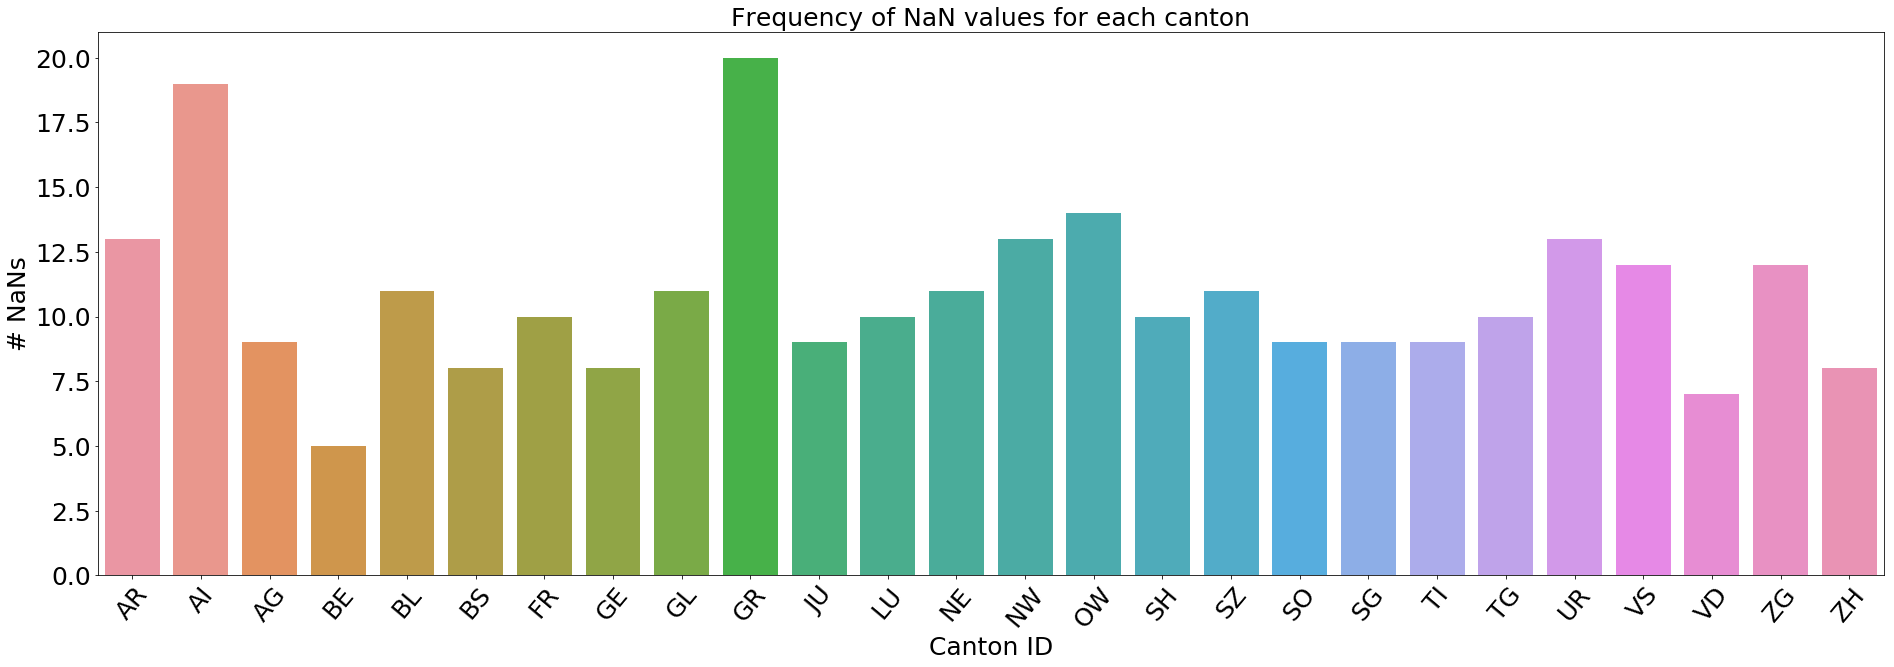

In [8]:
# do histogram of cantons vs number of NaN's 
# identify nan values in each row to see how many NaN values for each canton and identify outlier cantons
ax = plt.subplots(figsize=(32,10))
ax = sns.barplot(x=voters.index, y=voters.isnull().sum(axis=1), data=voters,);
ax.set_xticklabels(labels=voters.index.values, rotation=50, fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
ax.set_xlabel('Canton ID',fontsize=25)
ax.set_ylabel('# NaNs',fontsize=25)
ax.set_title('Frequency of NaN values for each canton', fontsize=25)
plt.show()

**Missing values (NaNs) are observed in the data with plot** `Frequency of NaN values for each canton`

* In the canton of *Appenzell Rh.-Int.* it is not possible to compute vote shares. This canton is considered as an outlier in further analysis.
> Dans le canton d'Appenzell Rh.-Int., il n'est pas possible de répartir les mandats par partis. Pourcentages impossibles à calculer, de nombreux arrondissements électoraux (voire la totalité) recourant au système majoritaire, ceci, en partie, lors d'assemblées communales.

* In the canton of *Grisons*, it is precised that votes shares were impossible to calculate, therefore, *Grisons* do not give us any information and may be removed from the analysis. It is an outlier and therefore we do not consider it for further analysis. It will remain NaN
> Pourcentages impossibles à calculer, de nombreux arrondissements électoraux (voire la totalité) recourant au système majoritaire, ceci, en partie, lors d'assemblées communales.

* In the canton of *Uri* some vote shares are not present because *Isenthal* and *Bauen* communes have a municipal assembly and in the commune of *Seedorf* there is a tacit election. Therefore for the canton of *Uri*, NaN values are set to 0 as the sum of all present share votes is 100%.
> UR: Dans la commune de Seedorf il y a eu une élection tacite. Dans les communes d'Isenthal et de Bauen il a eu une assemblée municipale. Il était donc impossible de calculer les pourcentages.

* Cantons of *Zoug*, *Schwitz*, *Valais*, *Argovie*, *Berne*, *Bâle-Campagne*, *Bâle-Ville*, *Fribourg*,*Genève*, *Glaris*, *Jura*, *Lucerne*, *Neuchâtel*, *Nidwald*, *Obwald*, *Schaffhouse*,*Soleure*, *St. Gall*, *Tessin*, *Thurgovie*, *Vaud*, *Zurich*:  NaN values for some political parties are present. They are set to 0 because the sum of vote shares sums up to 100% for the non-missing values. For *Appenzell Rh. Ext.*, the sum is 99.9 but we assume this is due to rounding errors and set all missing values to 0.


In [9]:
def preprocessing(the_voters, the_outliers=['GR', 'AI']):
    cantons_fillNA = [can_id for can_id in the_voters.index.values if can_id not in the_outliers]
    the_voters.loc[cantons_fillNA] = the_voters.loc[cantons_fillNA].fillna(0)
    return the_voters

In [10]:
#Processing NaN values
# outliers: Grisons GR and Appenzell Rh. Int. AI
voters = preprocessing(voters)

# check it out
voters.head(5)

,Canton,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PSA,PES,AVF,Sol.,DS,UDF,Lega,MCR,Autres,Total
id,,,,,,,,,,,,,,,,,,,,,
AR,Appenzell Rh. Ext.,2015,36.111260,35.526730,6.037578,11.475833,16.281936,0.0,2.149373,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,28.528551,100
AI,Appenzell Rh. Int.,2015,36.111260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…
AG,Argovie,2016,32.805153,15.997428,12.103790,18.918913,31.937510,0.0,4.048430,0.0,...,0.000000,7.051238,0.000000,0.0,0.000000,1.770212,0.0,0.0,0.207173,100
BE,Berne,2018,30.516313,11.717910,0.671415,22.328775,26.760869,0.0,6.172897,0.0,...,0.681873,10.104467,0.495841,0.0,0.179432,3.710624,0.0,0.0,0.912781,100
BL,Bâle-Campagne,2015,33.845621,19.029750,9.617786,21.995307,26.741611,0.0,5.365701,0.0,...,0.000000,9.577718,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,100


**A)** For the period 2014-2018, the following map shows the percentage of voters who voted for the party UDC.

* Let's use overlays to display cantonal borders as well as national borders.
* Load TopoJSON data/ch-cantons.topojson.json that contains the borders of the cantons.
* Overlay the canton boundaries on the swiss map. 
* Color according to percentage of UDC voters in each canton using a `style_function_UDC`
* Outlier cantons *Appenzell Rh.-Int* and *Grisons* will be painted in black using customized `style_function_UDC`

In [11]:
def style_function_UDC(feature, nan_color='#000000'):
    voter_UDC = voters.loc[feature['id']]['UDC']
    
    return {
        'fillOpacity': 0.7,
        'weight': 0,
        'fillColor':  nan_color if np.isnan(voter_UDC) else color_scale_UDC(voter_UDC)
    }

In [12]:
# swiss map 
alggi_alp_coord = [46.801111, 8.226667]
m_swiss = folium.Map(location=alggi_alp_coord, zoom_start = 8, tiles= 'Mapbox Bright')
# load 
geo_json_data = json.load(open(data_folder +'/ch-cantons.topojson.json')) #todo load in single form

# colorscale to attribute to % UDC
color_scale_UDC = branca.colormap.linear.BuPu_09.scale(
- np.abs(voters['UDC'].min()) - np.abs(voters['UDC'].min()) * .001,
np.abs(voters['UDC'].max()) + np.abs(voters['UDC'].max()) * .001)

folium.TopoJson(
    geo_json_data,
    'objects.cantons',
    style_function=style_function_UDC
).add_to(m_swiss)

print('Ranges of colors in map below: {}'.format(
    np.linspace(voters.loc[:, 'UDC'].min(), voters.loc[:, 'UDC'].max(), num=7, dtype=float))
     )

m_swiss

Ranges of colors in map below: [ 4.28632631  9.41734527 14.54836424 19.6793832  24.81040216 29.94142112
 35.07244008]


**Legend:** 
Cantons coloured with darker purple are the ones where the proportion of UDC voters is higher. The two outliers are coloured in black. Values associated with colours are indicated on top of the figure.

The UDC party seems to be more popular in the German-speaking part as the German-speaking cantons are colored in red (high percentage of UDC voters) in contrast to the Italian-speaking part (light yellow) or the French-speaking part (orange).

**B)** For the same period, we visualize the number of residents in each canton who voted for UDC.
For part B, you can use the data/national_council_elections.xslx file (guess where we got it from) to have the voting-eligible population of each canton in 2015

* Load `data/national_council_elections.xlsx` file. 
* Format canton names and remove rows containing only NaNs
* Put canton abbreviation as index (mapping with dictionary) using our function `create_mapping`

In [13]:
peops = pd.read_excel(
    data_folder + 'national_council_elections.xlsx', 
    sheet_name=0,
    skipfooter=10, # empirically
    header=7,
    names = ['Canton', 'Electeurs_inscrits', 'Electeurs', 'Participation_percentage']
    )
# drop rows
peops.dropna(axis=0, inplace=True, how='all')

# Replace all occurring digits and parathesis in the strings with nothing
peops.Canton = peops['Canton'].str.replace('\d+\)', '')

# sort according to the canton's name
peops.sort_values('Canton', inplace=True)

# construct mapping
my_peops_mapping = create_mapping(peops['Canton'].values.tolist())
    
# set index
peops['id'] = peops['Canton'].map(my_peops_mapping)
peops = peops.set_index('id')

peops.head(3)

,Canton,Electeurs_inscrits,Electeurs,Participation_percentage
id,,,,
AR,Appenzell Rh.-Ext.,38498.0,18131.0,47.095953
AI,Appenzell Rh.-Int.,11565.0,4247.0,36.722871
AG,Argovie,414745.0,200147.0,48.257845


**Number of residents that voted for UDC** To get the number of residents by canton, we merge `voters`and `peops`(containing number of people who voted in each canton) on `id`. Then, we compute the weighted number of electors that voted for UDC.  


$$\beta_X * electeurs_{C_X} $$

where $C_X$ is the canton X and $\beta_X$ is defined as following:

$$\frac{VoteShareUDC_{C_X} * electeurs_{C_X}}{\sum_i{VoteShareUDC_{C_i} * electeurs_{C_i}}}$$

The proportion of UDC voters for Canton X is normalized by the sum of the proportions of the other cantons. In such way, for the national election it will be more important to have Cantons with higher weight because it will mean to have more people voting for the party.

In [14]:
voters_UDC_people = voters.merge(peops, how='inner', on='id')[['UDC','Electeurs']]
denominator       = (voters_UDC_people['UDC']*voters_UDC_people['Electeurs']).sum()
beta              = voters_UDC_people['UDC']*voters_UDC_people['Electeurs']/denominator
UDC_people        = beta * voters_UDC_people['Electeurs']
UDC_people        = UDC_people.round()

id
GL       50.0
AR       90.0
UR       92.0
OW      100.0
NW      140.0
JU      160.0
NE      417.0
SZ      568.0
ZG      641.0
BS      788.0
SO      996.0
TI     1016.0
GE     1401.0
FR     2828.0
TG     3340.0
BL     3470.0
SG     3932.0
VS     4597.0
LU     7717.0
VD     8997.0
SH    12846.0
AG    21467.0
BE    57474.0
ZH    92642.0
AI        NaN
GR        NaN
dtype: float64

Describe:
count       24.000000
mean      9407.041667
std      21469.603533
min         50.000000
25%        352.750000
50%       1208.500000
75%       5377.000000
max      92642.000000
dtype: float64

Boxplot:


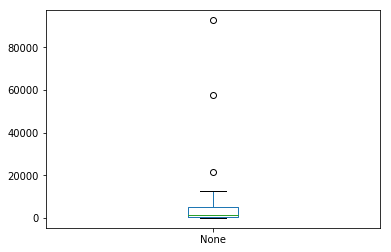

In [15]:
describe_serie(UDC_people)

It seems a power law. It is consistent because, looking at the formula above, we can see that the proportion computed it is just the number of active electors, that follow a power law, times a scalar $\beta$.

In [16]:
# TODO pietro power law con UDC_people

In [17]:
def style_function_UDC_peops(feature, nan_color='#000000'):
    voter_UDC_peops = UDC_people.loc[feature['id']]
    
    return {
        'fillOpacity': 0.7,
        'weight': 0,
        'fillColor':  nan_color if np.isnan(voter_UDC_peops) else color_scale_UDC_peops(voter_UDC_peops)
    }

In [18]:
# swiss map 
alp_coord = [46.801111, 8.226667]
m_swiss_UDC = folium.Map(location=alp_coord, zoom_start = 8, tiles= 'Mapbox Bright')
# load 
geo_json_data_UDC = json.load(open(data_folder +'/ch-cantons.topojson.json')) 

my_range = [100, 500, 1000, 3334, 5000, 12846]
my_colors = ['#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f']
color_scale_UDC_peops = branca.colormap.LinearColormap(
    colors=my_colors,
    index=my_range
)


folium.TopoJson(
    geo_json_data_UDC,
    'objects.cantons',
    style_function=style_function_UDC_peops
).add_to(m_swiss_UDC)

print('Ranges of colors in map below: {}'.format(my_range))
      
m_swiss_UDC

Ranges of colors in map below: [100, 500, 1000, 3334, 5000, 12846]


**Legend:** 
Cantons coloured with dark purple are the ones where the proportion of UDC voters is higher. The two outliers are coloured in black. Values associated with colours are indicated on top of the figure. The range is not linear since the distribution seems to follow a power law.

**C)** In the case of:
* a **national election** with majority voting, the most informative visualization would be the map in **Task 2B** because we need the number of residents having voted for each party in each canton to get a national estimate of the number of residents having voted for each party. We noticed that some small Cantons of the center of the country (AR, UR...) are colored in red in Task2A, reflecting a important pro-UDC proportion of electors. However, at national level (Task2B) they do not seem very important: they are colored in greyish because they do not have a lot of electors. Therefore, in order to win the national election, parties focus more on cantons that have big number of electors (VD, ZH...). 


* **cantonal parliament elections**, the most informative visualization would be the map in **Task 2A** because we are not interested in the number of residents, a proportion or percentage of voters for a given party with respect to the others in the canton is much more useful.

## Task 3: More socialism or more nationalism?

In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?

__B)__ For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.

### Solution 

In [19]:
# import voters for all years

footers = [55, 55, 51, 52, 48, 50, 52, 55]


voters_all_sheets = {
    '{}-{}'.format(k1, k2):[None, ] for k1,k2 in zip(
        range(2007, 2015)[::-1], 
        range(2010, 2018)[::-1]
    )
}

for (i, k), foot in zip(enumerate(voters_all_sheets.keys()), footers):
    voters_all_sheets[k] = import_voters(sheet_name=i, footer=foot)
    print(
        'Sheet {}: nb cantons {}, nb cols {}'.format(
            k, 
            voters_all_sheets[k].shape[0], 
            voters_all_sheets[k].shape[1]
        )
    )
    
print('nb of sheets imported {}'.format(len(voters_all_sheets)))

Sheet 2014-2017: nb cantons 26, nb cols 23
Sheet 2013-2016: nb cantons 26, nb cols 23
Sheet 2012-2015: nb cantons 26, nb cols 23
Sheet 2011-2014: nb cantons 26, nb cols 23
Sheet 2010-2013: nb cantons 26, nb cols 23
Sheet 2009-2012: nb cantons 26, nb cols 23
Sheet 2008-2011: nb cantons 26, nb cols 23
Sheet 2007-2010: nb cantons 26, nb cols 24
nb of sheets imported 8


In [20]:
# preprocessing
for voter in voters_all_sheets.values():
    voter = preprocessing(voter)
    
voters_all_sheets['2007-2010'].head()

,Canton,Année électorale,Participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PSA,PES,AVF,Sol.,DS,UDF,Lega,MCR,Autres,Total
id,,,,,,,,,,,,,,,,,,,,,
AR,Appenzell Rh. Ext.,2011,36.1821,33.808465,4.205485,10.981548,17.219986,0.0,2.160653,0.0,...,0.000000,0.362121,0.0,0.0,0.000000,0.000000,0.0,0.0,31.261741,100
AI,Appenzell Rh. Int.,2011,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…
AG,Argovie,2009,31.7365,14.304226,15.022673,15.732702,31.920765,0.0,4.468578,0.0,...,0.000000,8.887327,0.0,0.0,1.243283,1.755722,0.0,0.0,0.144715,100
BE,Berne,2010,32.3464,10.335474,1.256537,18.852832,26.621577,0.0,5.898273,0.0,...,1.039215,10.101410,0.0,0.0,0.414800,4.403570,0.0,0.0,0.977237,100
BL,Bâle-Campagne,2011,35.1064,15.150296,9.252803,21.986789,23.984895,0.0,4.736800,0.0,...,0.000000,13.689082,0.0,0.0,1.179291,0.000000,0.0,0.0,0.000000,100


#### 3A 

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:

$$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$  

Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?

---

In [21]:
# select only UDC and PS
voters_PS_UDC = voters_all_sheets['2014-2017'][['Année électorale', 'Participation', 'UDC', 'PS']].copy()
voters_PS_UDC.head()

,Année électorale,Participation,UDC,PS
id,,,,
AR,2015,36.111260,16.281936,11.475833
AI,2015,36.111260,NaN,NaN
AG,2016,32.805153,31.937510,18.918913
BE,2018,30.516313,26.760869,22.328775
BL,2015,33.845621,26.741611,21.995307


id
TI   -0.546968
BS   -0.388704
GE   -0.353025
NE   -0.344805
JU   -0.251881
VD   -0.193379
FR   -0.089296
SO   -0.040775
BE    0.090286
BL    0.097386
AR    0.173144
ZH    0.207214
SH    0.211421
VS    0.222613
OW    0.238281
AG    0.255987
SG    0.298405
UR    0.298833
GL    0.329381
LU    0.341078
TG    0.426341
ZG    0.437339
SZ    0.438521
NW    0.705789
AI         NaN
GR         NaN
dtype: float64

Describe:
count    24.000000
mean      0.106799
std       0.316521
min      -0.546968
25%      -0.115317
50%       0.209318
75%       0.306470
max       0.705789
dtype: float64

Boxplot:


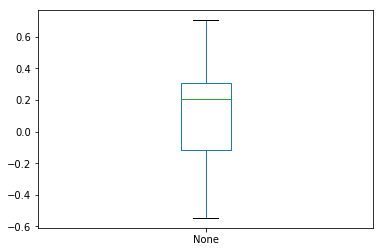

In [22]:
# compute right lean for each cantons
sum_ =  voters_PS_UDC.UDC + voters_PS_UDC.PS
difference_ = voters_PS_UDC.UDC - voters_PS_UDC.PS
right_leans = difference_/sum_

describe_serie(right_leans)

In [23]:
def style_function_right_lean(feature, nan_color='#000000'):
    right_lean = right_leans.loc[feature['id']]
    return {
    'fillOpacity': 0.7,
    'weight': 0,
    'fillColor':  nan_color if np.isnan(right_lean) else colorscale_right(right_lean),
    }

# plot
ch_coord = [46.8, 8.6]
geo_json_data = json.load(open(data_folder +'/ch-cantons.topojson.json'))
# Stamen Terrain, Stamen Toner, Mapbox Bright, and Mapbox Control Room, cartodbpositron
m_switzerland = folium.Map(ch_coord, tiles='Mapbox Bright', zoom_start=8)

my_range = np.linspace(right_leans.min(), right_leans.max(), num=7, dtype=float)
my_colors = ['#b2182b', '#ef8a62', '#fddbc7','#9e9ac8','#756bb1','#54278f']

colorscale_right = branca.colormap.LinearColormap(
    colors=my_colors,
    index=my_range,
    vmin=-np.abs(right_leans.min()) - np.abs(right_leans.min()) * .001,
    vmax= np.abs(right_leans.max()) + np.abs(right_leans.max()) * .001
)


folium.TopoJson(
    geo_json_data,
    'objects.cantons',
    style_function=style_function_right_lean
).add_to(m_switzerland)

print('Ranges of colors in map below: {}'.format(my_range))

m_switzerland

Ranges of colors in map below: [-0.54696798 -0.3381752  -0.12938242  0.07941036  0.28820314  0.49699592
  0.7057887 ]


**Legend:** Ranges are shown on the top of the figure. More red Cantons represent more `PS` (neg. values), greyish is the color for canton where the difference between `PS` and `UDC` is small (appr. zero) and purple areas represent cantons where the `UDC` is more present compared to `PS`.

Compared to the maps in *Task 2*, the colours are slightly different: e.g. in Bern and in Zurich in *Task 2* it looked like the `UDC` was greatly represented in those Cantons. Now, we can notice that the purple is less dark, that is the difference with the `PS` is not as big as one could have thought by looking at previous maps.


We can also notice that the `UDC` seems more present in the german-speaking Catons compared to the freanch-speaking cantons. In the italian-speaking canton the `PS` seems more present than `UDC`.

#### 3B

For each party (`UDC`, `PS`), we visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. 

We use the relative difference for both parties, for each canton, for years 2018-2014 vs 2013-2010.

$$\frac{VoteShare2018_{party} - VoteShare2013_{party}}{VoteShare2018_{party} + VoteShare2013_{party}}$$  

In [24]:
# compute the lean, i.e. the relative difference for each canton, for each party
party_2017 = voters_all_sheets['2014-2017'][voters_all_sheets['2014-2017'].columns[3:-1]]
party_2013 = voters_all_sheets['2010-2013'][voters_all_sheets['2010-2013'].columns[3:-1]]

# lean (relative difference)
lean = (party_2017 - party_2013)/(party_2017 + party_2013)

# remove all the nan that arrise from 0/0
lean = preprocessing(lean)

lean = lean[['UDC', 'PS']].copy()
lean.head()

,UDC,PS
id,,
AR,-0.028000,0.022010
AI,NaN,NaN
AG,-0.001009,0.109021
BE,-0.039829,0.077049
BL,0.054345,0.000194


id
NE   -0.190288
GE   -0.170864
TI   -0.092548
GL   -0.065558
NW   -0.058584
BE   -0.039829
VD   -0.037226
AR   -0.028000
BS   -0.024827
VS   -0.022941
SZ   -0.013251
UR   -0.011846
SO   -0.010857
AG   -0.001009
ZG    0.000000
OW    0.001349
ZH    0.006498
SH    0.021297
FR    0.029342
TG    0.033133
LU    0.043016
BL    0.054345
SG    0.075600
JU    0.167180
AI         NaN
GR         NaN
Name: UDC, dtype: float64

Describe:
count    24.000000
mean     -0.013995
std       0.073205
min      -0.190288
25%      -0.037877
50%      -0.011351
75%       0.023308
max       0.167180
Name: UDC, dtype: float64

Boxplot:


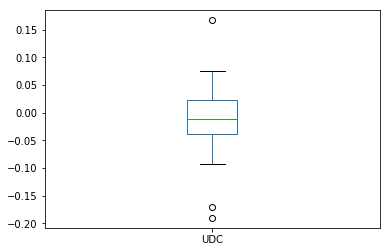

In [25]:
describe_serie(lean['UDC'])

In [26]:
m_switzerland = folium.Map(ch_coord, tiles='Mapbox Bright', zoom_start=8)

my_range = np.linspace(lean['UDC'].min(), lean['UDC'].max(), num=7)
my_colors = ['#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f']
color_scale_UDC_peops = branca.colormap.LinearColormap(
    colors=my_colors,
    index=my_range
)

colorscale_leanUDC = branca.colormap.LinearColormap(
    colors=my_colors,
    index=my_range,
    vmin=-np.abs(lean['UDC'].min()) - np.abs(lean['UDC'].min()) * .001,
    vmax= np.abs(lean['UDC'].max()) + np.abs(lean['UDC'].max()) * .001
)


def style_functionUCD(feature, nan_color='#000000'): 
    the_lean = lean.loc[feature['id'], 'UDC']
    return {
    'fillOpacity': 0.7,
    'weight': 0,
    'fillColor':  nan_color if np.isnan(the_lean) else colorscale_leanUDC(the_lean),
    }

In [27]:
folium.TopoJson(
    geo_json_data,
    'objects.cantons',
    style_function=style_functionUCD,
    name='UDC'
).add_to(m_switzerland)

print('Ranges of colors in map below: {}'.format(my_range))

m_switzerland

Ranges of colors in map below: [-0.19028848 -0.13071034 -0.07113221 -0.01155408  0.04802405  0.10760218
  0.16718031]


In [28]:
m_switzerland = folium.Map(ch_coord, tiles='Mapbox Bright', zoom_start=8)


def style_functionPS(feature, nan_color='#000000'): 
    the_lean = lean.loc[feature['id'], 'PS']
    return {
    'fillOpacity': 0.7,
    'weight': 0,
    'fillColor':  nan_color if np.isnan(the_lean) else colorscale_leanPS(the_lean),
    }


my_range = np.linspace(lean['PS'].min(), lean['PS'].max(), num=6)
my_colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000']

colorscale_leanPS = branca.colormap.LinearColormap(
    colors=my_colors,
    index=my_range
)

folium.TopoJson(
    geo_json_data,
    'objects.cantons',
    style_function=style_functionPS,
    name='PS'
).add_to(m_switzerland)

print('Ranges of colors in map below: {}'.format(my_range))


m_switzerland

Ranges of colors in map below: [-0.06447657 -0.02977705  0.00492248  0.039622    0.07432153  0.10902105]


**Legend:** The more red the color of a caton, the more vote shares it has acquired in contrast to 2010-2013. Outliers are in black and ranges are shown in at the top of the figure.

Let's consider the Canton of Jura. In the map from Task2, we noticed that the Jura percentage of vote for `UDC` was not very high. However, looking at the map in 3B (purple map above), we can see that the Jura is the Canton where the `UDC` increased the most the proportion of electors. We can imagine that the`UDC` will still increase the proportion the next years and maybe beat the `PS` at the next elections, as the `PS`does not seem to have increased the consensus during the latest years. We should finally keep in mind that these are qualitative analyses.